## About
This notebook generates a number of figures for the paper:

1. Aligned scattering curves for the 53 high quality datasets analyzed using the MFF factor to obtain a consistently determined $R_g$ value.
2. Correlation and comparison for those high quality scattering datasets
3. Assessment of A1-LCD variant distributions and comparison of derived scattering curves


### Changelog
* 2025-04-28; Added `ANAC013_161_274`

In [29]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import matplotlib as mpl

mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1

mpl.rcParams['xtick.major.size'] = 2  # Major tick length for x-axis
mpl.rcParams['xtick.minor.size'] = 0.5   # Minor tick length for x-axis
mpl.rcParams['ytick.major.size'] = 2  # Major tick length for y-axis
mpl.rcParams['ytick.minor.size'] = 0.5   # Minor tick length for y-axis

mpl.rcParams['xtick.major.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.major.width'] = 0.375  # Major tick width for y-axis
mpl.rcParams['xtick.minor.width'] = 0.375  # Major tick width for x-axis
mpl.rcParams['ytick.minor.width'] = 0.375  # Major tick width for y-axis

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.375

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# i ssue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)
from tqdm.auto import tqdm


REALIGN_WITH_HOUSETOOLS = True

In [30]:
# NB: we (holehouse lab) have an internal package which includes a set of internal
# tools called housetools; if we are running this internally, the following code allows
# us to rebuild the "aligned" curves from the ensembles. However, it's worth noting
# all this is code the aligns experimental an simulated scattering curves to ensure I(q)
# values match up, so nothing fancy! If you're regenerating the figures there is no need
# to do this the pre-aligned curves are provided as pickle files.
if REALIGN_WITH_HOUSETOOLS:
    from housetools.methods import saxs

    
## Initial pre-amble for making nice figures
import os
import pickle
import numpy as np
import matplotlib
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import string  
import protfasta
from starling import load_ensemble

In [12]:
##
## Helper functions for quality of life
##

def get_clean_filename(input_name, directory):
    """
    Check if there's a file with the suffix '_clean.dat' in the directory.
    If such a file exists, return its path; otherwise, return the directory.
    
    Args:
        input_name (str): The base name to check for '_clean.dat' suffix.
        directory (str): The directory to search.
    
    Returns:
        str: The full path to the '_clean.dat' file if found, otherwise the directory.
    """
    # Construct the potential '_clean.dat' filename

    input_name_no_extension = input_name[:-4]
    
    clean_filename = f"{input_name_no_extension}_clean.dat"    
    clean_filepath = os.path.join(directory, clean_filename)

    # Check if the file exists
    if os.path.isfile(clean_filepath):
        return clean_filepath
    elif os.path.isfile(os.path.join(directory, input_name)):
        return os.path.join(directory, input_name)
    else:
        print(os.path.join(directory, input_name))
        raise Exception('Could not find file')    

def read_pickle(fn):
    """Reads a pickle file and returns the stored object."""
    with open(fn, "rb") as f:
        return pickle.load(f)

def write_pickle(fn, outdict):
    """Writes a dictionary (or any object) to a pickle file."""
    with open(fn, "wb") as f:
        pickle.dump(outdict, f, protocol=pickle.HIGHEST_PROTOCOL)        

### Start of the notebook

In [13]:
seqs = protfasta.read_fasta('experiment/sequences.fasta')
names = list(seqs.keys())

In [14]:
saxs_rgs = {}
with open('experiment/mff_analysis_all.csv','r') as fh:
    content = fh.readlines()
for line in content: 
    sline = line.strip().split(',')
    if len(sline) == 3:
        saxs_rgs[sline[0]] = float(sline[1])

In [31]:
if REALIGN_WITH_HOUSETOOLS:

    # build the aligned curves
    for idx, n in tqdm(enumerate(names)):

        # get the filename
        exp_file = get_clean_filename(f'{n}.dat', f'experiment/{n}')
        # define parameters we use for aligning...
        qmin_fit = 0.01
        qmax_fit = 0.25
        qmax_fit_chi2 = 0.15
        d = saxs.fit_scattering_curves(exp_file, f'ensembles/{n}/average_curve.dat',qmin=qmin_fit, qmax=qmax_fit, verbose=False)
    
        write_pickle(f'scattering_curves/{n}.pkl', d)


0it [00:00, ?it/s]

In [33]:
# plotting options
show_axes = True
use_log   = True
show_fitting_region = False
show_legend = False

for idx, n in tqdm(enumerate(names)):
    
    # size here VERY finely tuned to match figure
    figure(num=None, figsize=(1.5, 1.18), dpi=150, facecolor='w', edgecolor='k')

    ax = plt.gca()

    d = read_pickle(f'scattering_curves/{n}.pkl')
    I0 = d[0]['D2_Iq'][0]
    
    plt.errorbar(d[0]['D1_q'], d[0]['D1_Iq']/I0, yerr=d[0]['D1_Iq_error']/I0, fmt='o', linewidth=0.2, markersize=0.5, color='k', mew=0.4, alpha=0.2)
    
    plt.plot(d[0]['D2_q'], d[0]['D2_Iq']/I0, '-', linewidth=0.35, markersize=0.5, color='r', zorder=10, mew=0.2, alpha=1)
    
    if show_fitting_region:
        ax.axvspan(d[2]['q_min_fitting'], d[2]['q_max_fitting'], color='yellow', alpha=0.1, lw=0)
        ax.axvline(d[2]['q_min_fitting'], color='b', lw=0.2)
        ax.axvline(d[2]['q_max_fitting'], color='b', lw=0.2)
    
    if use_log:
        plt.xscale('log')
        plt.yscale('log')

    if show_axes:
        plt.xlabel('q', fontsize=7)
        plt.ylabel('I(q)', fontsize=7)
        plt.xticks(fontsize=5)
        plt.yticks(fontsize=5)
        plt.title(n, fontsize=5)
    else:
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks([])
        plt.yticks([])
    
    if show_legend:
        plt.legend(['Experiment', 'Simulation'])
    plt.xlim([0.003, 0.4])    
    plt.ylim([0.0005, 2])    
    
    plt.tight_layout()
    if show_axes:
        if use_log:
            plt.savefig(f'figures/with_axes/{n}.pdf')
        else:
            plt.savefig(f'figures/with_axes/lin_lin_{n}.pdf')
    else:
        if use_log:
            plt.savefig(f'figures/no_axes/{n}.pdf')
        else:
            plt.savefig(f'figures/no_axes/lin_lin_{n}.pdf')

    # close each figure so we don't generate a ton of images in the nb
    plt.close()
    


0it [00:00, ?it/s]

### Singular plot
Function here generates a single multi-panel plot with aligned scattering curves. Same data as the preceding cell but as a single figure format for the supplementary information.

0it [00:00, ?it/s]

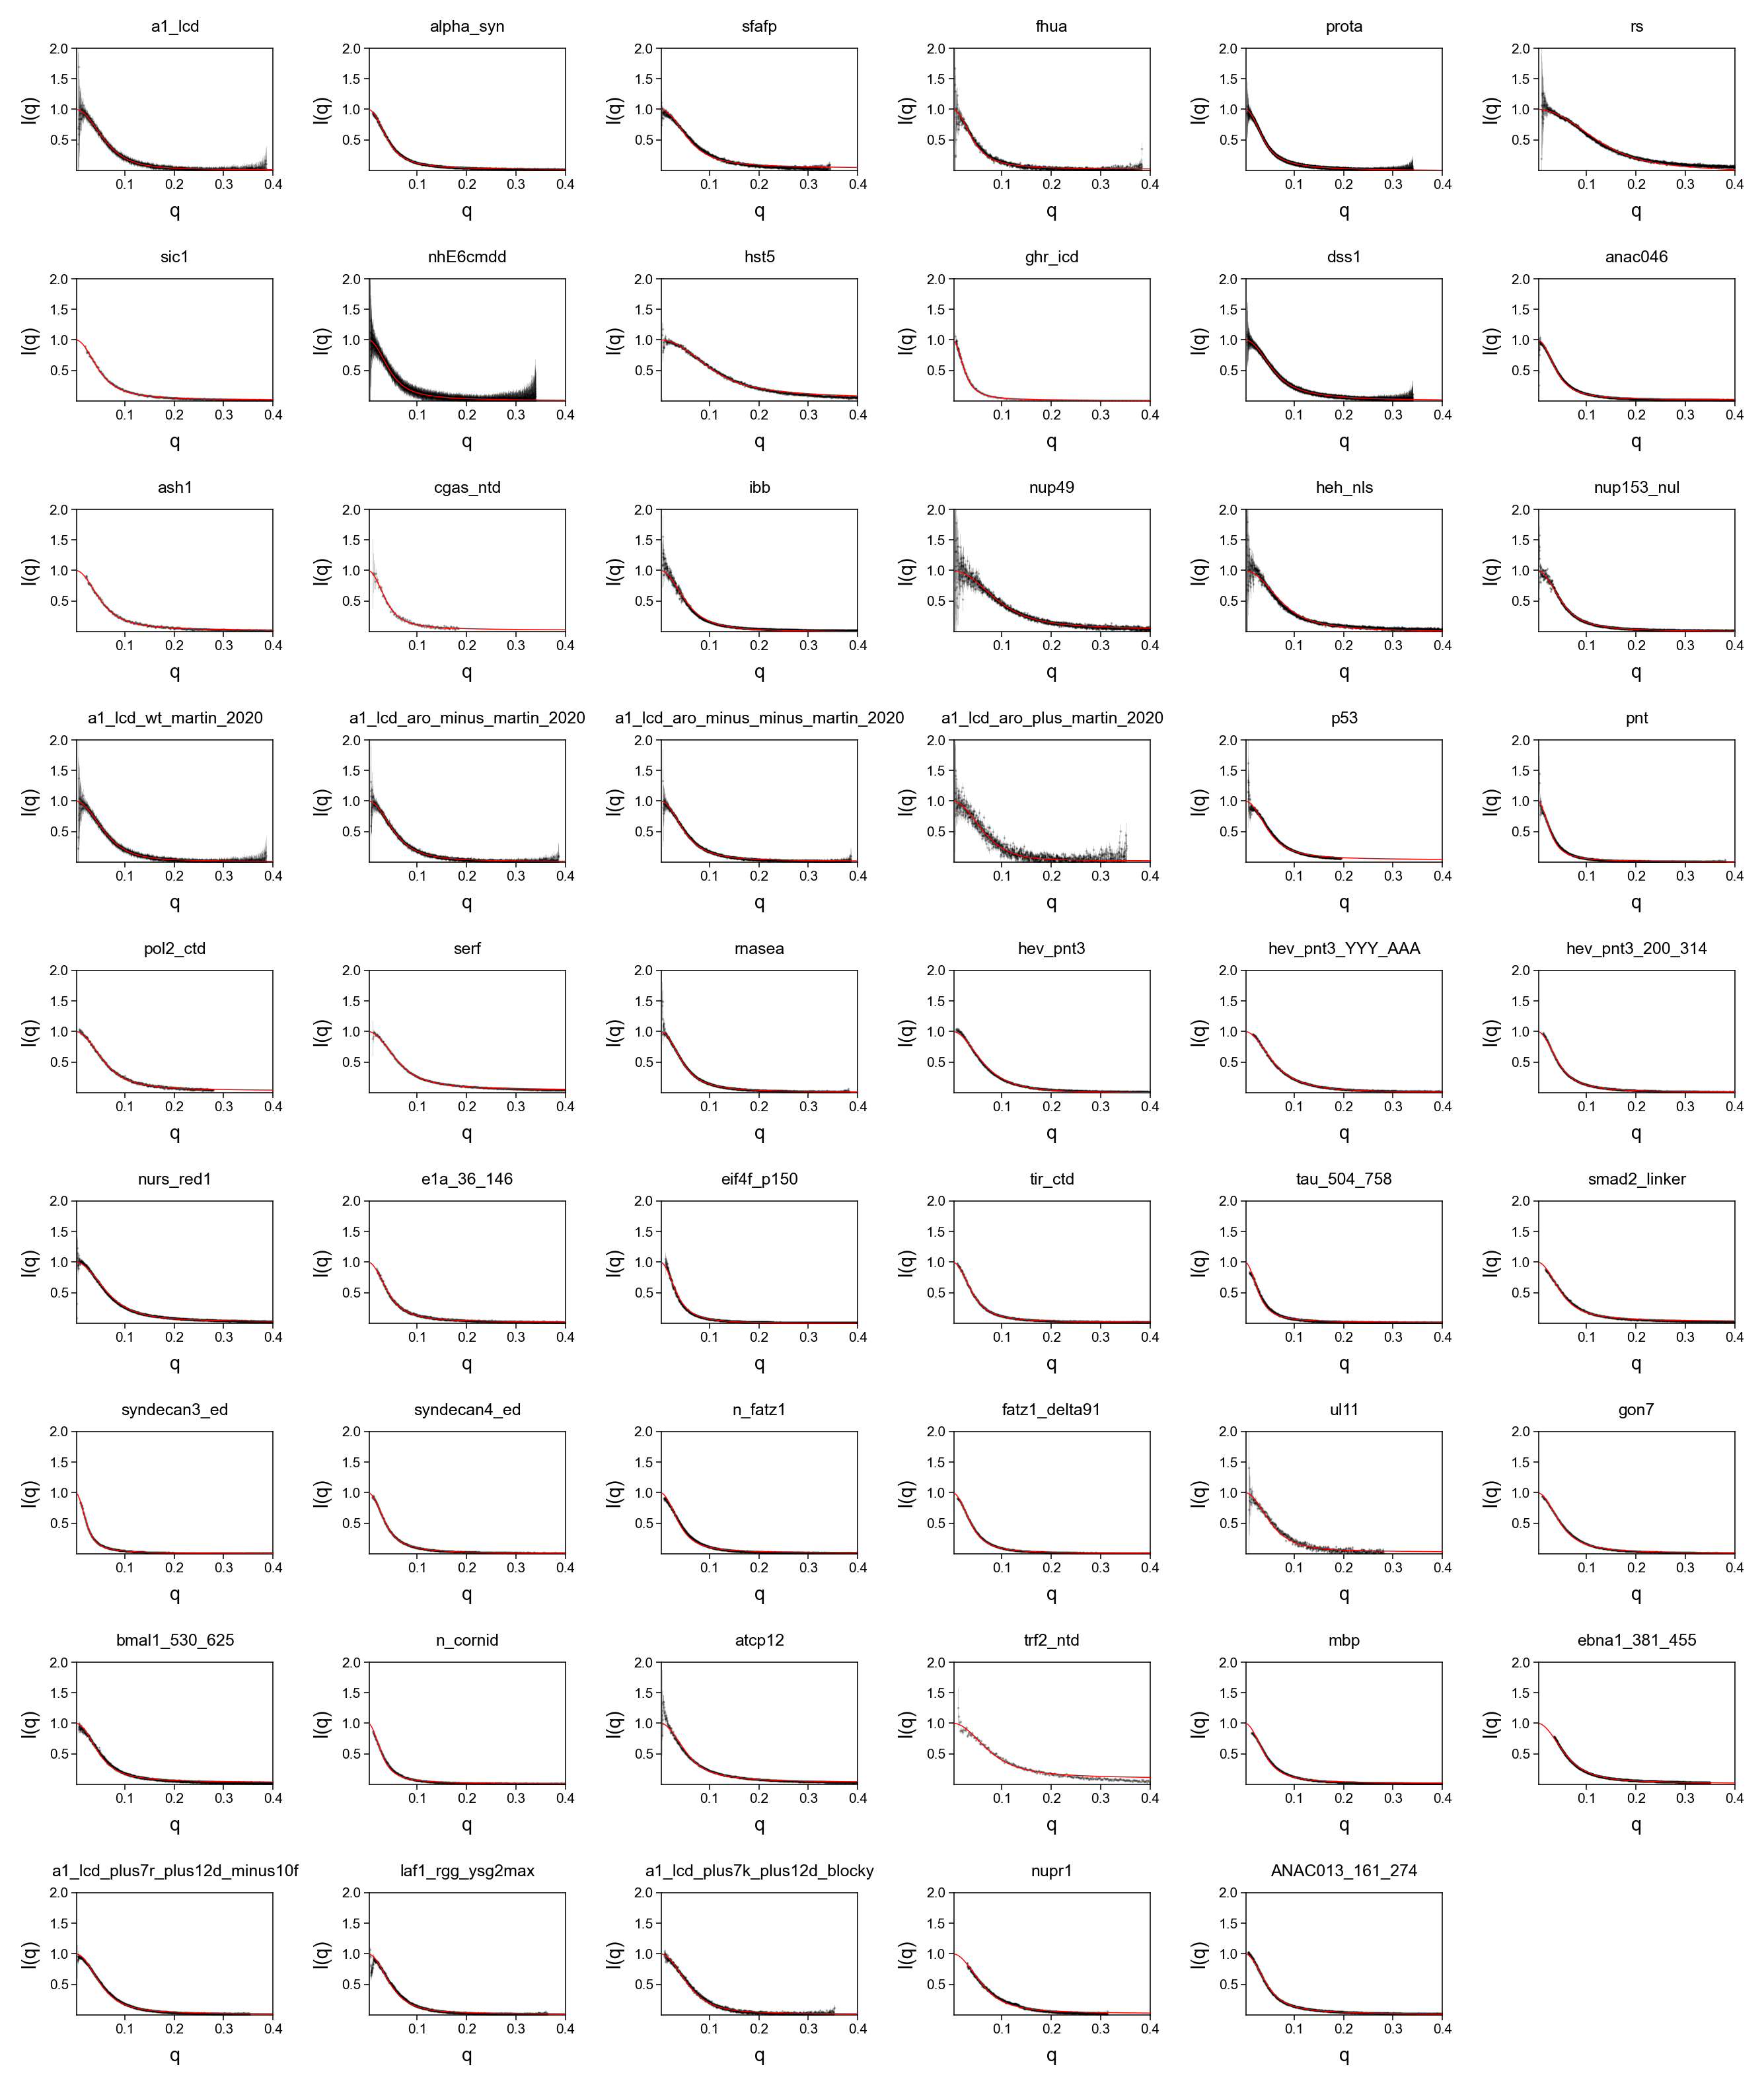

In [34]:
def plot_saxs_scattering(names, show_fitting_region=False, use_log=True):
    n_cols = 6
    n_rows = 9
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.18), dpi=150)
    axes = axes.flatten()
    
    #for idx, n in enumerate(names[:55]):
    for idx, n in tqdm(enumerate(names)):
        ax = axes[idx]        
        d = read_pickle(f'scattering_curves/{n}.pkl')


        
        I0 = d[0]['D2_Iq'][0]
        ax.errorbar(d[0]['D1_q'], d[0]['D1_Iq']/I0, yerr=d[0]['D1_Iq_error']/I0, fmt='o', linewidth=0.2, markersize=0.5, color='k', mew=0.4, alpha=0.2)
        ax.plot(d[0]['D2_q'], d[0]['D2_Iq']/I0, '-', linewidth=0.35, markersize=0.5, color='r', zorder=10, mew=0.2, alpha=1)
        
        if show_fitting_region:
            ax.axvspan(d[2]['q_min_fitting'], d[2]['q_max_fitting'], color='yellow', alpha=0.1, lw=0)
            ax.axvline(d[2]['q_min_fitting'], color='b', lw=0.2)
            ax.axvline(d[2]['q_max_fitting'], color='b', lw=0.2)

        if use_log:
            ax.set_xscale('log')            
            ax.set_yscale('log')
            
        ax.set_xlabel('q', fontsize=7)
        ax.set_ylabel('I(q)', fontsize=7)
        ax.tick_params(axis='both', which='both', labelsize=5)
        ax.set_xlim([0.003, 0.4])
        ax.set_ylim([0.0005, 2])
        ax.set_title(n, fontsize=6)

    
    for j in range(idx + 1, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    if use_log:
        plt.savefig('figures/all_scattering_profiles.pdf')
        plt.savefig('figures/all_scattering_profiles.png',dpi=450)
    else:
        plt.savefig('figures/lin_lin_all_scattering_profiles.pdf')
        plt.savefig('figures/lin_lin_all_scattering_profiles.png',dpi=450)
        

plot_saxs_scattering(names, use_log=False)


## Comparison of averag $R_g$ values from
The code below compares average and distribution (as box-plot) $R_g$ values from STARLING with average $R_g$ values obtained using the molecular form factor of Riback et al. We pre-computed $R_g$ values by analyzing all 53 scattering curves using the MFF and obtaining the $R_g$ value from the output.

In [35]:
# read in experimental Rg values from the MFF-derived analysis
saxs_rgs = {}
with open('experiment/mff_analysis_all.csv','r') as fh:
    content = fh.readlines()
for line in content: 
    sline = line.strip().split(',')
    if len(sline) == 3:
        saxs_rgs[sline[0]] = float(sline[1])

In [36]:
# extract out the STARLING derived Rg values
starling_ensembles = {}
starling_rgs = {}
starling_rg_dist = {}

# 
for n in saxs_rgs.keys():

    # read the ensemble
    starling_ensembles[n] = load_ensemble(f'ensembles/{n}/{n}.starling')

    # extract mean rg
    starling_rgs[n] = starling_ensembles[n].radius_of_gyration(return_mean=True)

    # get the distribution
    starling_rg_dist[n] = starling_ensembles[n].radius_of_gyration()

# rebuild the starling_rgs dictionary sorted on the rg values from smallest to largest
starling_rgs = dict(sorted(starling_rgs.items(), key=lambda x: x[1]))

# build a list of lists to encompass the distributions
# now ordered according to smallest to largest Rg
rg_dists = []
for k in starling_rgs:
    rg_dists.append(starling_rg_dist[k])




/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_4862/2332404183.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


0.9732135301657684


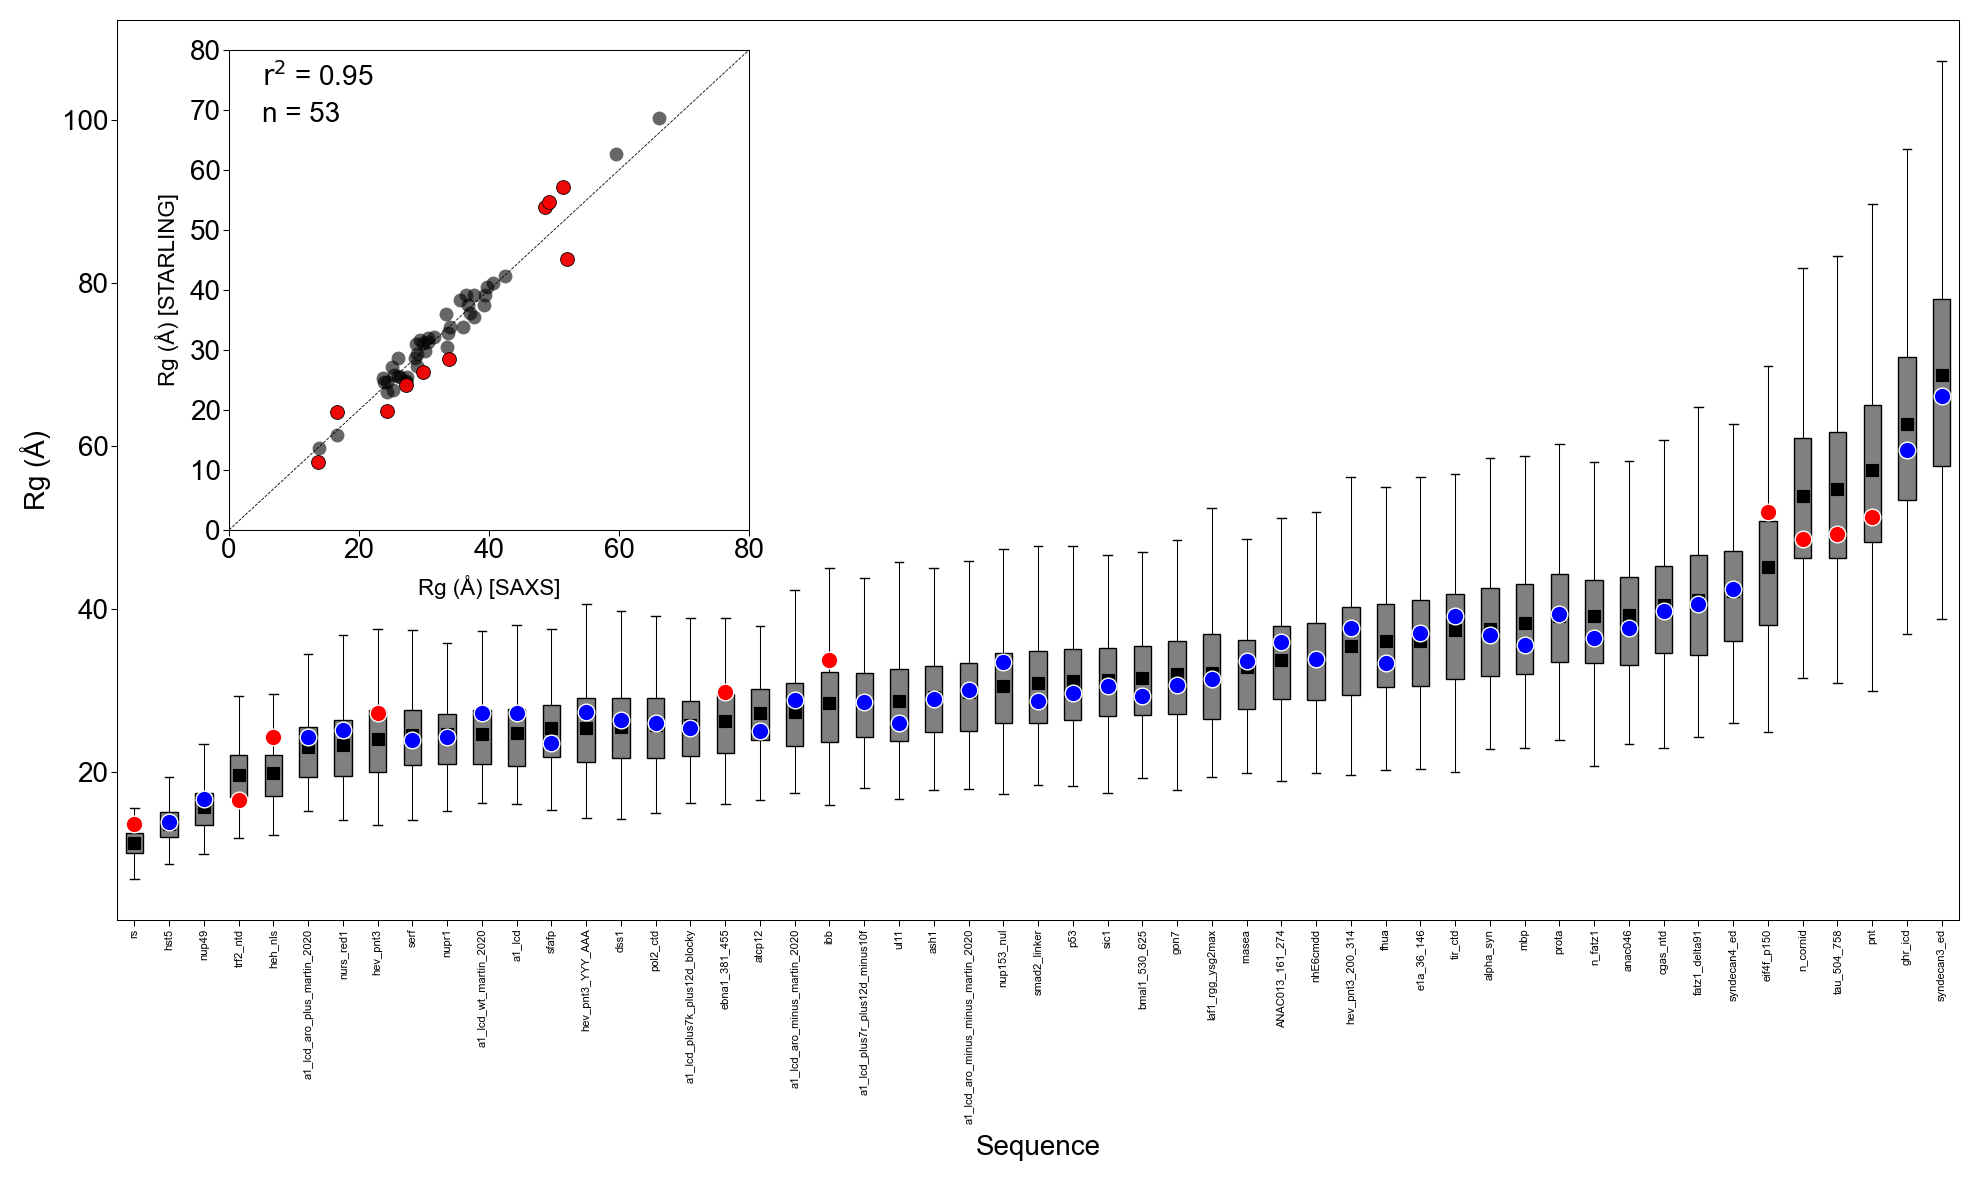

In [38]:
# Create main figure and axis
fig, ax = plt.subplots(figsize=(10, 6))  # Main figure

# box plot baby!
ax.boxplot(
    rg_dists, 
    patch_artist=True, 
    showmeans=True,  # Show means
    showfliers=False,  # Hide outliers
    medianprops={'visible': False},  # Hide the median
    boxprops={'facecolor': 'grey', 'linewidth':0.5},
    capprops={'linewidth': 0.5},  # Set the linewidth for caps

    whiskerprops={'linewidth': 0.375},  # Set the linewidth for whiskers

    meanprops={'marker': 's', 'markerfacecolor': 'black', 'markeredgecolor': 'black', 'ms':4, 'mew':0.4}  # Customize mean
)

# highlight those proteins were scattering agreement is poor
bad_prots = ['rs', 'heh_nls', 'hev_pnt3', 'ibb', 'trf2_ntd',
             'eif4f_p150', 'tau_504_758', 'n_cornid', 'pnt',
             'ebna1_381_455']

# for each SAXS value, draw as blue if not in the bad_prots list, or red if yes
for idx, k in enumerate(starling_rgs):        
    if k in bad_prots:
        plt.plot(idx+1, saxs_rgs[k],'o', zorder=10, mew=0.5, mec='w', color='red')
        
    else:
        plt.plot(idx+1, saxs_rgs[k],'o', zorder=10, mew=0.5, mec='w', color='blue')

# draw tick labeles
plt.xticks(np.arange(1,len(starling_rgs)+1), starling_rgs, fontsize=4, rotation=90)    

# write axis labels
plt.xlabel('Sequence')  # X-axis label
plt.ylabel('Rg (Å)')  # Y-axis label

# define the location of the inset
inset_ax = fig.add_axes([0.12, 0.55, 0.26, 0.4])  # [x, y, width, height] (relative to the figure)

# go and grab the experimental and average rg values, along
# with the names
exp_rg = []
star_rg = []
rg_names = []
for k in starling_rgs:
    exp_rg.append(saxs_rgs[k])
    star_rg.append(starling_rgs[k])
    rg_names.append(k)
    
# calculate r2 as square of the Pearson product-moment correlation coefficient between
# experiment and prediction
r2 = np.power(np.corrcoef(exp_rg,star_rg)[0][1],2)

# plot average values
inset_ax.plot(exp_rg, star_rg,'ok', ms=5, mew=0, alpha=0.6)

# draw x=y line
inset_ax.plot([0,80],[0,80], lw=0.3, c='k', ls='--')

# walk through and (1) select all the "good" data and (2) annotate the bad 
# average values on the experiment vs. starling
good_exp_rg = []
good_star_rg = []
for idx, n in enumerate(rg_names):
    if n in bad_prots:
        inset_ax.plot(exp_rg[idx], star_rg[idx],'or', ms=5, mew=0.3, alpha=0.9, mec='k')

    else:
        good_exp_rg.append(exp_rg[idx])
        good_star_rg.append(star_rg[idx])

# calculate r2 as square of the Pearson product-moment correlation coefficient between
# experiment and prediction for just the sequences where scattering data fit well...
r2_good = np.power(np.corrcoef(good_exp_rg,good_star_rg)[0][1],2)

inset_ax.text(5, 74, r"$\rm{r^{2}}$ = " + f"{round(r2,2)}")
inset_ax.text(5, 68, f"n = {len(exp_rg)}")

inset_ax.set_xlabel('Rg (Å) [SAXS]', fontsize=8)
inset_ax.set_ylabel('Rg (Å) [STARLING]', fontsize=8)

inset_ax.set_xlim([0, 80])
inset_ax.set_ylim([0,80])
plt.tight_layout()

# we just print this for our own 
print(r2_good)
plt.savefig('figures/big_saxs.pdf')



In [43]:

if REALIGN_WITH_HOUSETOOLS:
    qmin=0.01
    qmax=0.25

    # wt vs minus minus
    n1 = 'ensembles/a1_lcd_wt_martin_2020/average_curve.dat'
    n2 = 'ensembles/a1_lcd_aro_minus_minus_martin_2020/average_curve.dat'
    d = saxs.fit_scattering_curves(n1, n2, qmin=qmin, qmax=qmax, verbose=False)    
    write_pickle(f'scattering_curves/a1_comparisons/wt_vs_minus_minus.pkl', d)

    
    n2 = 'ensembles/a1_lcd_aro_minus_martin_2020/average_curve.dat'
    d = saxs.fit_scattering_curves(n1, n2, qmin=qmin, qmax=qmax, verbose=False)    
    write_pickle(f'scattering_curves/a1_comparisons/wt_vs_minus.pkl', d)

    n2 = 'ensembles/a1_lcd_aro_plus_martin_2020/average_curve.dat'
    d = saxs.fit_scattering_curves(n1, n2, qmin=qmin, qmax=qmax, verbose=False)       
    write_pickle(f'scattering_curves/a1_comparisons/wt_vs_plus.pkl', d)


### Plot scattering curves
Generate profiles for scattering curves of A1-LCD WT +3 variants

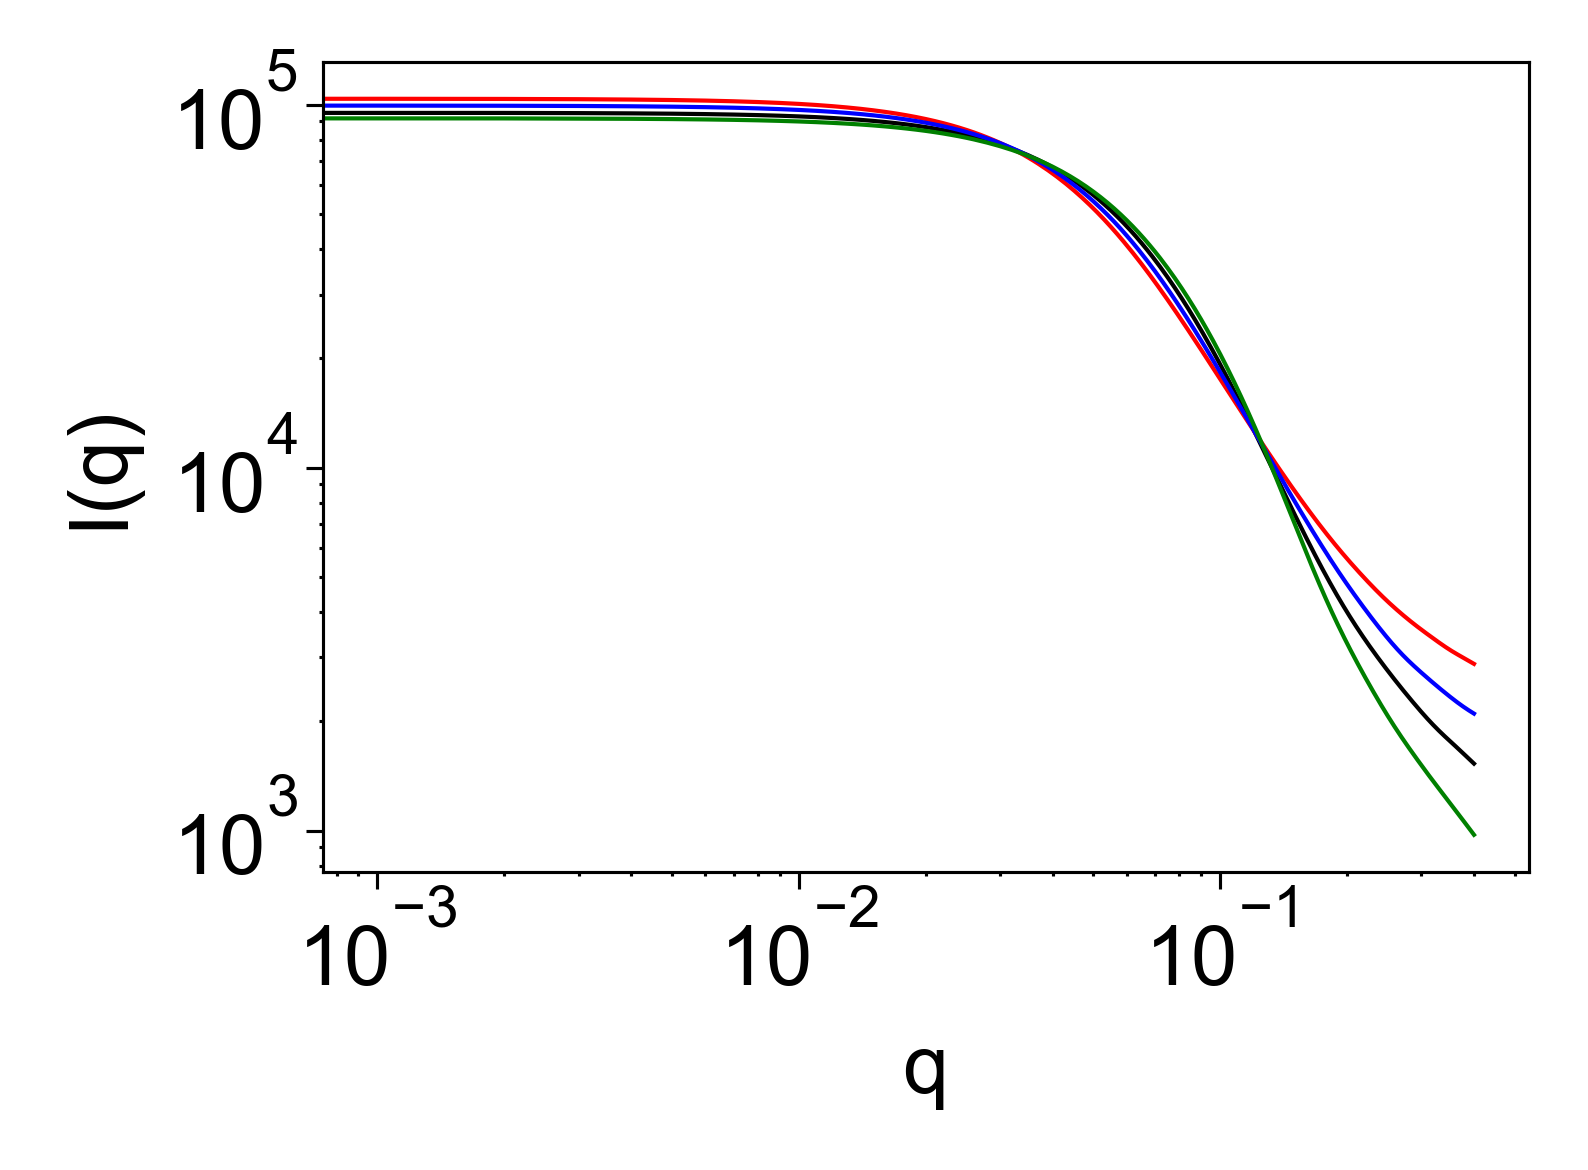

In [47]:
d1 = read_pickle(f'scattering_curves/a1_comparisons/wt_vs_minus_minus.pkl')
d2 = read_pickle(f'scattering_curves/a1_comparisons/wt_vs_minus.pkl')
d3 = read_pickle(f'scattering_curves/a1_comparisons/wt_vs_plus.pkl')


figure(None, (3,2), dpi=300)
plt.plot(d1[0]['D1_q'], d1[0]['D1_Iq'], '-', linewidth=0.5, markersize=0.5, color='k', label='wt')
plt.plot(d1[0]['D2_q'], d1[0]['D2_Iq'], '-', linewidth=0.5, markersize=0.5, color='r', label='minmin')
plt.plot(d2[0]['D2_q'], d2[0]['D2_Iq'], '-', linewidth=0.5, markersize=0.5, color='b', label='min')
plt.plot(d3[0]['D2_q'], d3[0]['D2_Iq'], '-', linewidth=0.5, markersize=0.5, color='g', label='plus')
plt.xlabel('q')
plt.ylabel('I(q)')
#plt.legend(frameon=False, fontsize=5)
plt.tight_layout()


plt.xscale('log')
plt.yscale('log')

plt.savefig(f'figures/a1_lcd_calibration.pdf')


# Compare histograms for large ensembles
Here, we load in the BIG (10,000 conformer) ensembles to compare experimental vs. STARLING derived ensembles

In [48]:
# load in BIG ensembles
wt              = load_ensemble('ensembles_10000_confs/a1_lcd_wt_martin_2020.starling')
aro_plus        = load_ensemble('ensembles_10000_confs/a1_lcd_aro_plus_martin_2020.starling')
aro_minus       = load_ensemble('ensembles_10000_confs/a1_lcd_aro_minus_martin_2020.starling')
aro_minus_minus = load_ensemble('ensembles_10000_confs/a1_lcd_aro_minus_minus_martin_2020.starling')

# extract out Rg values
a1_lcd_rg_starling = {}
a1_lcd_rg_starling['wt'] = wt.radius_of_gyration()
a1_lcd_rg_starling['aro_plus'] = aro_plus.radius_of_gyration()
a1_lcd_rg_starling['aro_minus'] = aro_minus.radius_of_gyration()
a1_lcd_rg_starling['aro_minus_minus'] = aro_minus_minus.radius_of_gyration()

# define SAXS values
a1_lcd_rg_exp = {}
a1_lcd_rg_exp['wt'] = 25.83
a1_lcd_rg_exp['aro_plus'] = 24.2
a1_lcd_rg_exp['aro_minus'] = 27.9
a1_lcd_rg_exp['aro_minus_minus'] = 29.3


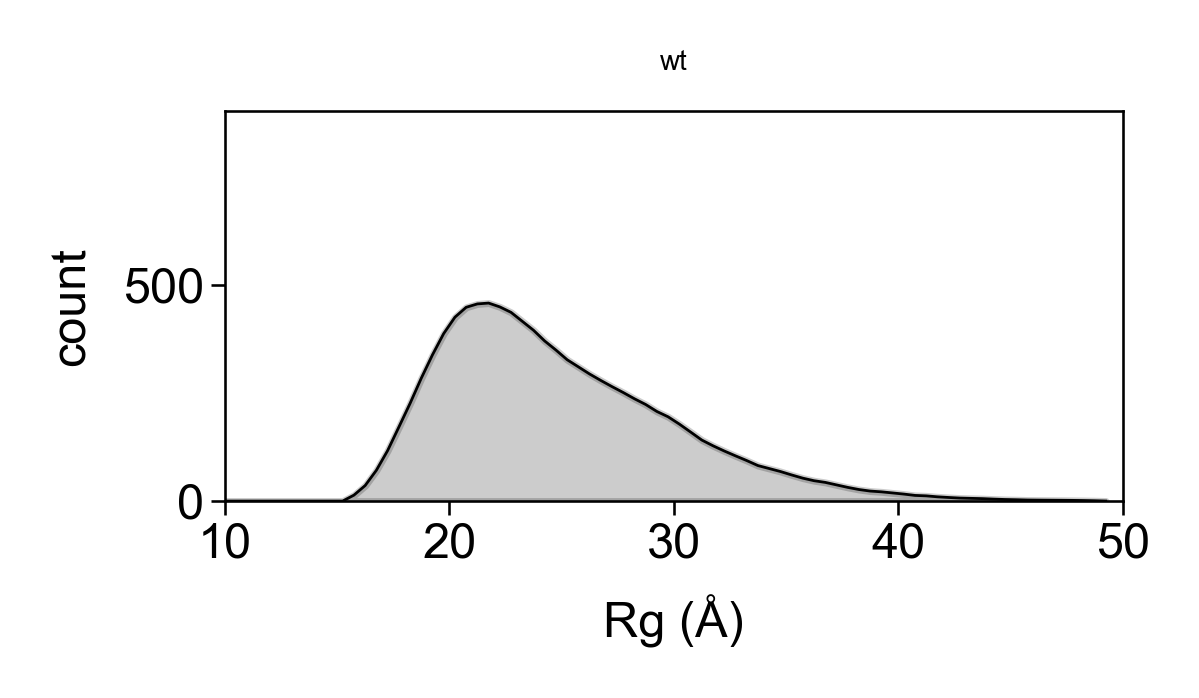

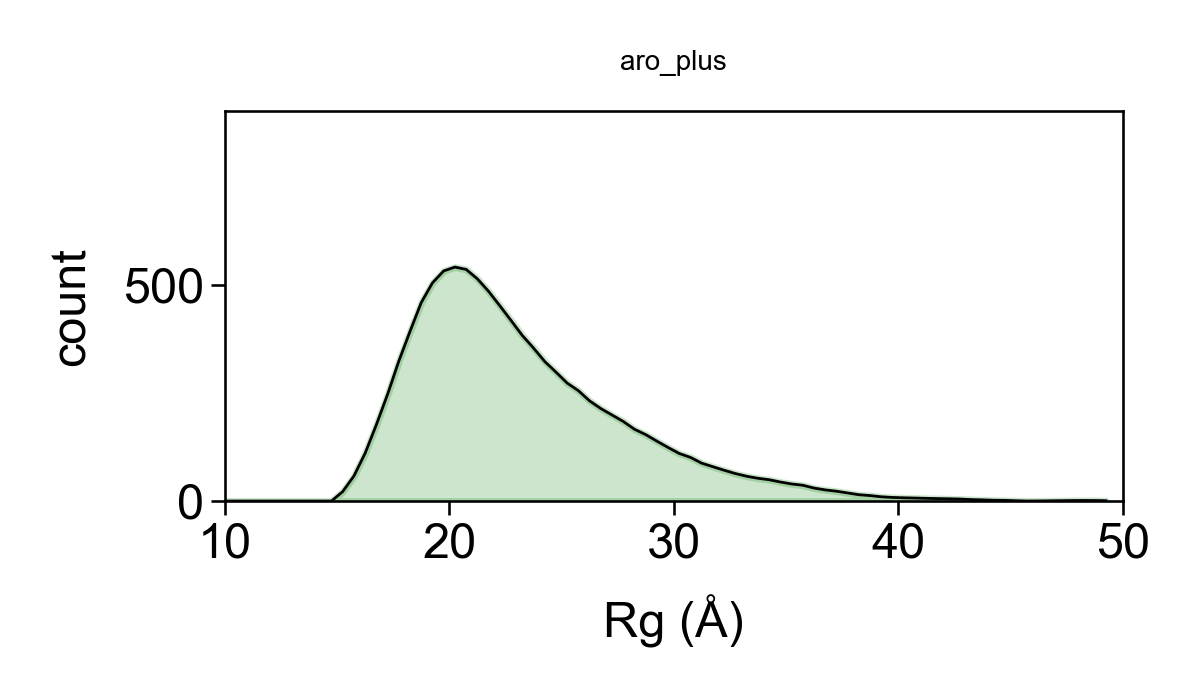

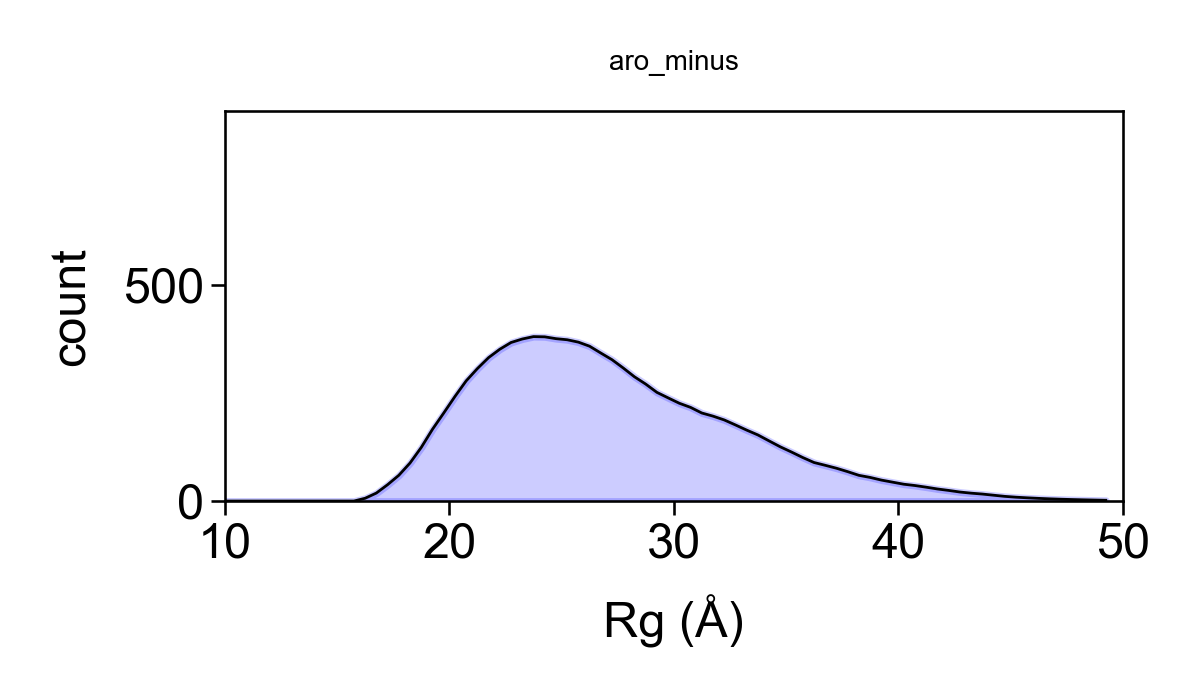

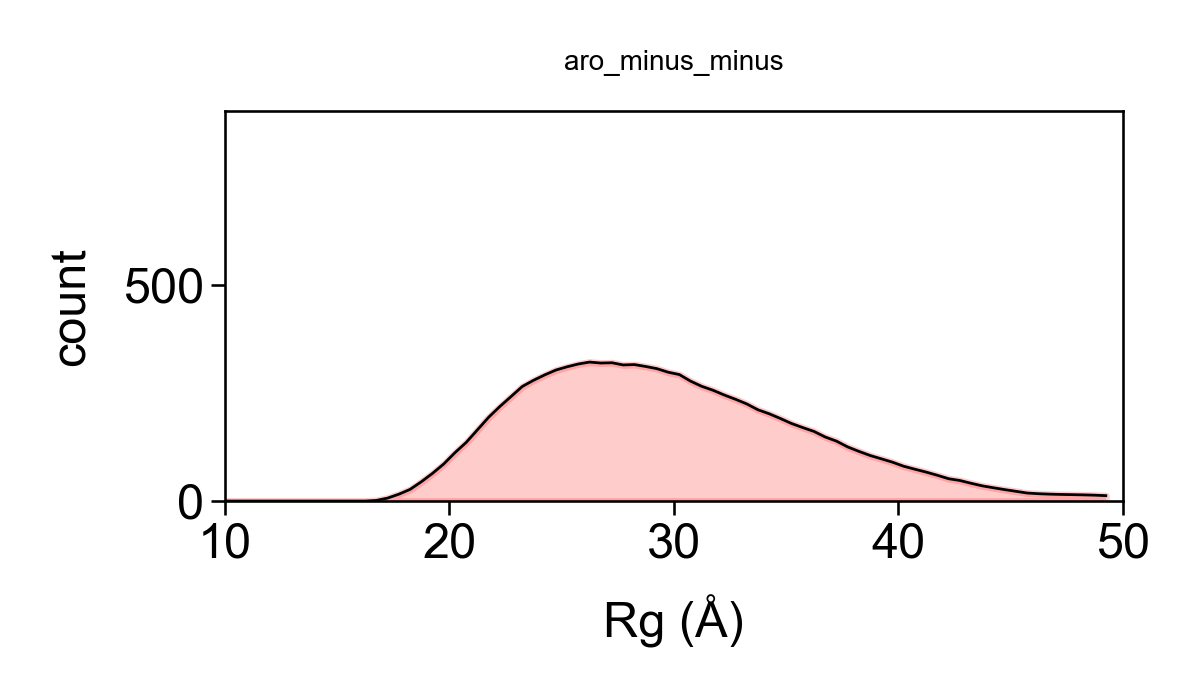

In [49]:
def get_histogram_vals(vals, bw=1, bmin=0,bmax=50, wl=15, polyorder=3):
    
    bins = np.arange(bmin,bmax,bw)
    [a,b]= np.histogram(vals,bins=bins)
    
    smoothed = savgol_filter(a,wl,polyorder)

    smoothed[smoothed<0]=0
    return b[1:]-bw*0.5, a, smoothed

def plot_histo(n, fn, color):        
    figure(None, (2.5, 1.5), dpi=250)
    ax = plt.gca()
    bw=0.5
    X = get_histogram_vals(a1_lcd_rg_starling[n], bw=bw)
    plt.plot(X[0],X[2], color='k', lw=0.4)
    plt.fill_between(X[0], 0, X[2], alpha=0.2, color=color)
    #plt.bar(X[0],X[1], width=bw*0.8, color=color,alpha=0.4, edgecolor='k',lw=0.1)
    plt.ylim([0,900])
    plt.xlim([10,50])
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.ylabel('count', fontsize=7)
    plt.xlabel('Rg (Å)', fontsize=7)
    plt.title(n, fontsize=4)
    #ax.axvline(a1_lcd_rg_exp[n], color=color,lw=1, alpha=0.9)
    #ax.axvline(np.mean(a1_lcd_rg_starling[n]), color='k',lw=1, alpha=0.7,ls='--')
    
    plt.tight_layout()
    plt.savefig(fn)


# plot histograms for the four A1 LCD variants
plot_histo('wt','figures/a1_lcd_histograms/wt_rg_distribution.pdf', 'k')
plot_histo('aro_plus','figures/a1_lcd_histograms/aro_plus_rg_distribution.pdf', 'g')
plot_histo('aro_minus','figures/a1_lcd_histograms/aro_minus_rg_distribution.pdf', 'b')
plot_histo('aro_minus_minus','figures/a1_lcd_histograms/aro_minus_minus_rg_distribution.pdf', 'r')
    
    

# Plot violin plots for A1-LCD variants
Final cell, we plot the A1-LCD variants $R_g$ distributions of violin plots with experimental average values overlaid.

/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_4862/2166053766.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sk" (-> color='k'). The keyword argument will take precedence.
  plt.plot([4],[a1_lcd_rg_exp['aro_minus_minus']],'sk', color='r', ms=2)
/var/folders/2n/xtzsyspd32v6vglg_pd5gmw80000gn/T/ipykernel_4862/2166053766.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)  # Adjust y-tick label font size


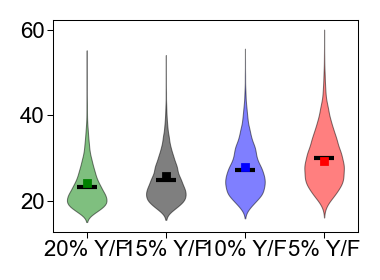

In [51]:

# Colors for each violin
colors = ['green', 'black', 'blue', 'red']

# Create the violin plot
fig, ax = plt.subplots(figsize=(2,1.5))
parts = ax.violinplot([a1_lcd_rg_starling['aro_plus'], a1_lcd_rg_starling['wt'], a1_lcd_rg_starling['aro_minus'], a1_lcd_rg_starling['aro_minus_minus']], showmeans=True, showextrema=False, showmedians=False)

# Customize the colors of the violins
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    pc.set_linewidth(0.37)  # Adjust edge width (set to desired value)

# Customize other elements
for partname in ('cmeans', 'cmedians', 'cbars'):
    if partname in parts:
        parts[partname].set_edgecolor('black')


plt.plot([1],[a1_lcd_rg_exp['aro_plus']],'s',color='green', ms=2)
plt.plot([2],[a1_lcd_rg_exp['wt']],'s', color='k', ms=2)
plt.plot([3],[a1_lcd_rg_exp['aro_minus']],'s', color='b', ms=2)
plt.plot([4],[a1_lcd_rg_exp['aro_minus_minus']],'sk', color='r', ms=2)

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['20% Y/F', '15% Y/F', '10% Y/F', '5% Y/F'])

ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)  # Adjust x-tick label font size
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)  # Adjust y-tick label font size

plt.tight_layout()

plt.savefig('figures/a1_lcd_histograms/aro_violins.pdf')
